**Trích xuất thông tin từ tập dứ liệu, import các thư viện cần thiết**

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from pyvi.ViTokenizer import tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import json
import numpy as np
from sklearn.preprocessing import normalize

dataset_path = 'D:\GitHub\masterthesis\data\Stsbenchmark\stsbenchmark\output_2017_data.xlsx'
# MODEL_PATH = 'd:/GitHub/masterthesis/data/llama_embedding_data.json'
MODEL_PATH = 'D:/GitHub/masterthesis/data/llama_embedding_data_english.json'

In [37]:
def load_dataset_and_groundtruth(dataset_path):

    #Dataset đã được review lại
    df = pd.read_excel(dataset_path)
    #Dataset đã được tách theo concept sử dụng cho độ đo jaccard và LCS
    # df2 = pd.read_excel('d:/GitHub/masterthesis/data/ViSTS_concept.xlsx')

    # Loại bỏ các dòng có giá trị NaN nếu có
    df = df.dropna(subset=['Câu 1', 'Câu 2'])
    # df2 = df2.dropna(subset=['Câu 1', 'Câu 2'])

    #Trích xuất các câu từ dataset
    all_sentences = list(df['Câu 1']) + list(df['Câu 2'])
    # all_sentences_concept = list(df2['Câu 1']) + list(df2['Câu 2'])

    ground_truth = list(df['Similarity Score'])
    return all_sentences, ground_truth

all_sentences, ground_truth = load_dataset_and_groundtruth(dataset_path)

**Thiết lập cách tính toán tại mỗi layer**

In [38]:
def jaccard_similarity(sent1, sent2):
    #tách từ sinh viên => sinh_viên
    #trọng số ?
    # Tokenize the sentences into words
    words1 = set(sent1.lower().split())
    words2 = set(sent2.lower().split())

    # Calculate the intersection and union of the word sets
    intersection = words1.intersection(words2)
    union = words1.union(words2)

    # Jaccard similarity is the size of the intersection divided by the size of the union
    jaccard_score = len(intersection) / len(union) if len(union) > 0 else 0

    return jaccard_score

def LCSubstr(s1, s2):
    ws1 =  s1.split()
    ws2 =  s2.split()
    l1= len(ws1)
    l2= len(ws2)
    m= max(l1, l2)+1
    F = np.zeros( (m, m) )
    for i in range(len(ws1)):
        for j in range(len(ws2)):
            if ws1[i]==ws2[j]:
                F[i+1,j+1] = F[i,j] +1
            else:
                F[i+1,j+1]  = max(F[i,j+1] , F[i+1,j] )
    return F[l1, l2] / max(l1, l2)

def word_movers_distance(embedding1, embedding2):
    # Calculate distance matrix
    distance_matrix = cdist(embedding1, embedding2, metric='euclidean')
    
    # Normalize the embeddings to create probability distributions
    p = np.ones(len(embedding1)) / len(embedding1)
    q = np.ones(len(embedding2)) / len(embedding2)
    
    # Solve the transportation problem
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Calculate WMD
    wmd = np.sum(distance_matrix[row_ind, col_ind])
    return wmd


**Tính toán phân bố của bộ dữ liệu với lớp Cosine Sim, Jaccard, LCS**

In [39]:
def load_embedding_from_model(model_path):
    #Sử dụng embedding từ các mô hình
    with open(model_path, 'r') as file:
        data = json.load(file)
    embeddings = data["data"]
    return embeddings

def normalized_embeddings(embeddings):
    # Convert list to NumPy array before normalizing
    embeddings_array = np.array(embeddings)

    # Now apply normalization
    normalized_embeddings = normalize(embeddings_array, axis=1)
    return normalized_embeddings

embeddings = normalized_embeddings(load_embedding_from_model(MODEL_PATH))

# print(embeddings[0])
# print(normalized_embedding[0])

In [40]:
print(all_sentences[0], all_sentences[125])

Our current vehicles will be in museums when everyone has their own aircraft. The car needs to some work


In [80]:
print(cosine_similarity([embeddings[26]], [embeddings[150]]))

[[0.7284327]]


In [42]:
def get_distribution_cosine_similarity():
  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n) 
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(cosine_similarity([embeddings[i]], [embeddings[i+n]]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))
  return scores

def get_distribution_wmd(embeddings, all_sentences):
    n = len(all_sentences) // 2
    distances = []
    print("DF length: ", n)
    
    # WMD between sentence pairs (Sentence 1 and Sentence 2)
    for i in range(n):
        wmd = word_movers_distance(
            embedding1=embeddings[i].reshape(1, -1),
            embedding2=embeddings[i+n].reshape(1, -1)
        )
        distances.append(wmd)
    
    # WMD within Sentence 1 group
    for i in range(n):
        for j in range(i+1, n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
    
    # WMD within Sentence 2 group
    for i in range(n, 2*n):
        for j in range(i+1, 2*n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
            
    return distances

def get_distribution_jaccard_similarity():
  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(jaccard_similarity(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))
  return scores

def get_distribution_lcs_similarity():
  # n = len(df)
  n = len(all_sentences) // 2
  # Lấy các similarity scores
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(LCSubstr(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))
  return scores

In [43]:
cosine_sim_distribution = get_distribution_cosine_similarity()
jaccard_distribution = get_distribution_jaccard_similarity()
lcs_distribution = get_distribution_lcs_similarity()

DF length:  125
DF length:  125
DF length:  125


In [44]:
def find_most_frequent_distribution(distribution):
    scores = np.array(distribution).flatten()

    # Create histogram
    hist, bin_edges = np.histogram(scores, bins=50)

    # Find the index of the bin with the highest count
    max_count_index = np.argmax(hist)

    # Get the center of the bin with the highest count
    most_frequent_value = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2

    print(f"Bin with highest distribution: {most_frequent_value}")
    print(f"Number of items in this bin: {hist[max_count_index]}")

find_most_frequent_distribution(cosine_sim_distribution)
find_most_frequent_distribution(jaccard_distribution)
find_most_frequent_distribution(lcs_distribution)


Bin with highest distribution: 0.6898854088825421
Number of items in this bin: 1286
Bin with highest distribution: 0.07
Number of items in this bin: 2986
Bin with highest distribution: 0.009375
Number of items in this bin: 4390


In [20]:
##Vẽ dis char
# Chuyển scores thành numpy array 1 chiều
import numpy as np
def distribution_chart():

  scores = np.array(cosine_sim_distribution).flatten()

  scores2 = np.array(jaccard_distribution).flatten()

  scores3 = np.array(lcs_distribution).flatten()

  # scores4 = np.array(wmd_distribution).flatten()
  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores, bins=50, kde=True)
  plt.title('Phân bố Cosine Similarity Scores')
  plt.xlabel('Cos Similarity Score')
  plt.ylabel('Số lượng')
  plt.show()


  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores2, bins=50, kde=True)
  plt.title('Phân bố Jaccard Similarity Scores')
  plt.xlabel('Jaccard Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores3, bins=50, kde=True)
  plt.title('Phân bố LCS Similarity Scores')
  plt.xlabel('LCS Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  # plt.figure(figsize=(12, 8))
  # sns.histplot(scores4, bins=50, kde=True)
  # plt.title('Phân bố WMD Similarity Scores')
  # plt.xlabel('WMD Score')
  # plt.ylabel('Số lượng')
  # plt.show()
  # Vẽ biểu đồ phân bố
  # score4_mean = []
  # for i in range(0, len(jaccard_distribution)):
  #   score4_mean.append( (jaccard_distribution[i] + lcs_distribution[i])/2)

  # plt.figure(figsize=(12, 8))
  # sns.histplot(score4_mean, bins=50, kde=True)
  # plt.title('Phân bố LCS+Jacard Similarity Scores')
  # plt.xlabel('LCS+Jaccard Score')
  # plt.ylabel('Số lượng')
  # plt.show()

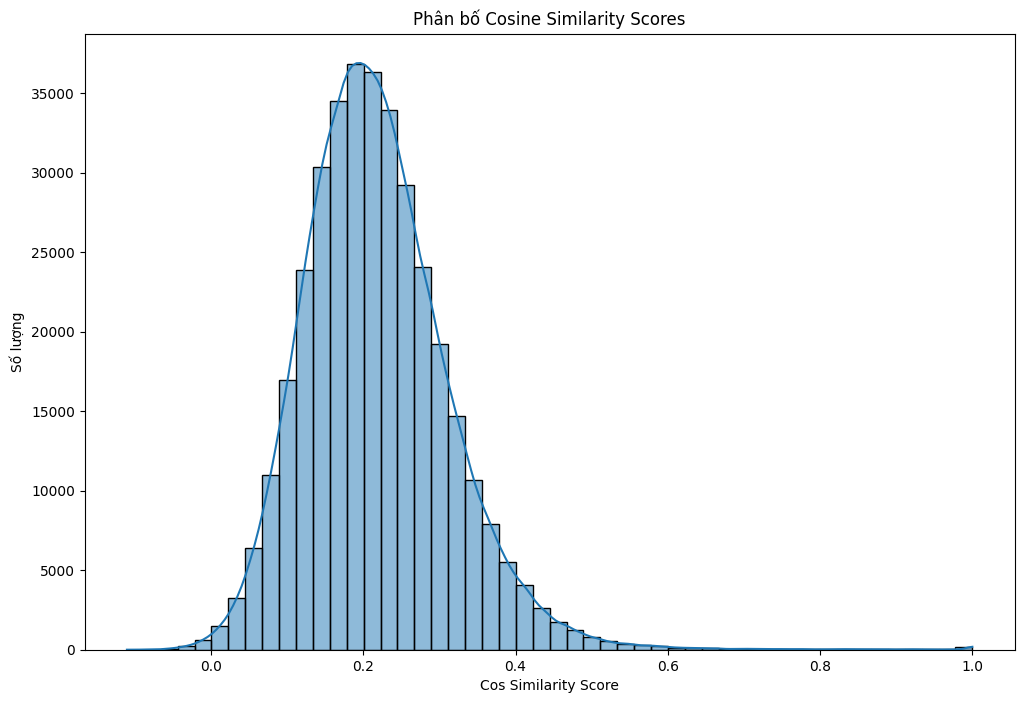

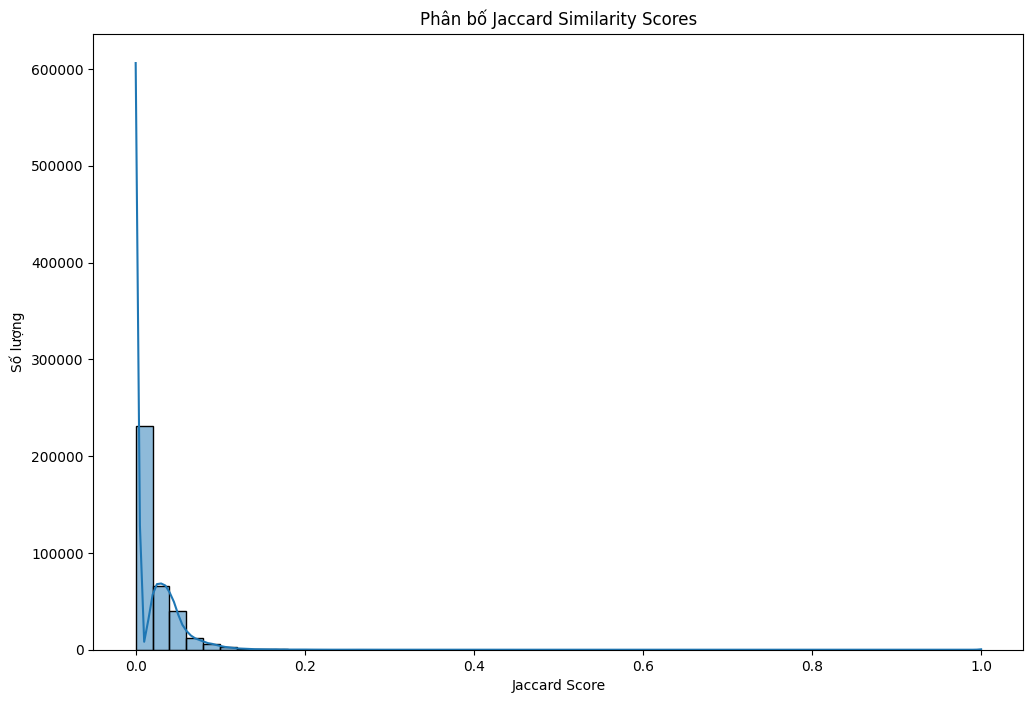

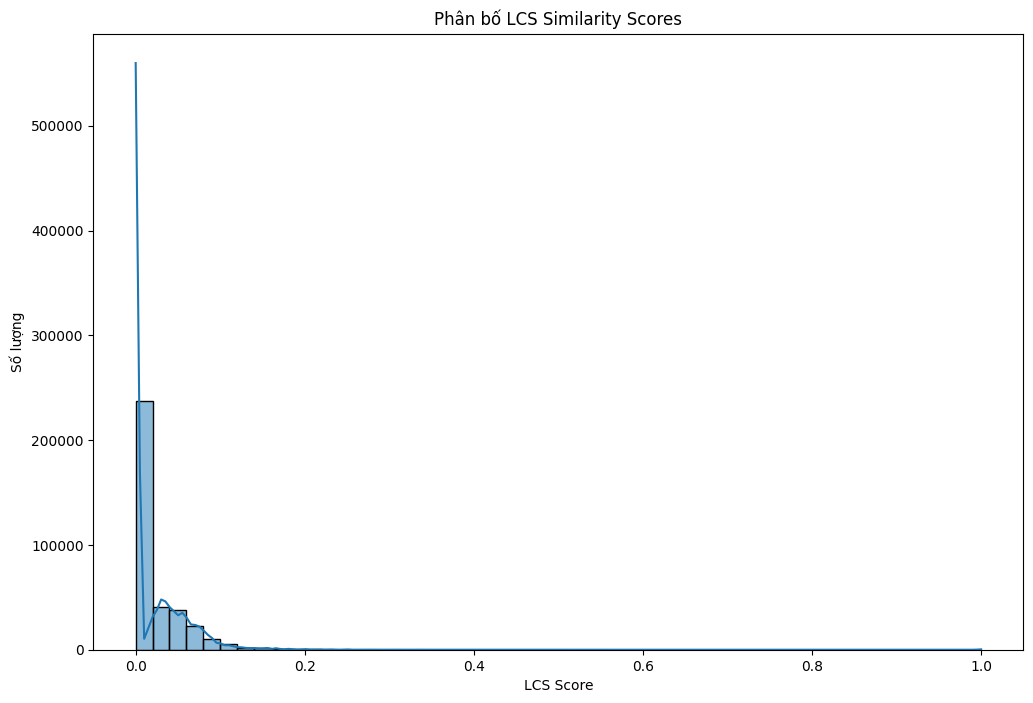

In [21]:
distribution_chart()

In [45]:
import numpy as np
from scipy.spatial.distance import jensenshannon

dist1_flat = []
for arr in cosine_sim_distribution:
  # print(arr[0][0])
  dist1_flat.append(arr[0][0])

def safe_jensenshannon_for_lists(dist1, dist2, epsilon=1e-10):
    # Convert to numpy arrays and handle potential issues
    dist1_array = np.array(dist1, dtype=float)
    dist2_array = np.array(dist2, dtype=float)


    # Add small epsilon to prevent zero probabilities
    dist1_safe = dist1_array + epsilon
    dist2_safe = dist2_array + epsilon

    # Normalize distributions
    dist1_norm = dist1_safe / np.sum(dist1_safe)
    dist2_norm = dist2_safe / np.sum(dist2_safe)

    # Ensure non-negative and sum to 1
    dist1_norm = np.maximum(dist1_norm, 0)
    dist2_norm = np.maximum(dist2_norm, 0)
    dist1_norm /= np.sum(dist1_norm)
    dist2_norm /= np.sum(dist2_norm)

    # Calculate Jensen-Shannon divergence
    try:
        js_distance = jensenshannon(dist1_norm, dist2_norm)
        return js_distance
    except Exception as e:
        print("Calculation error:", e)
        return None

# Usage
result = safe_jensenshannon_for_lists(dist1_flat, jaccard_distribution)
print("Jensen-Shannon Distance CosJac:", result)

result2 = safe_jensenshannon_for_lists(dist1_flat, lcs_distribution)
print("Jensen-Shannon Distance CosLCS:", result2)

result3 = safe_jensenshannon_for_lists(lcs_distribution, jaccard_distribution)
print("Jensen-Shannon Distance LCSJac:", result3)

print("Sum: ", (result + result2 + result3))
print("Main: ", (result + result2 + result3)/3)
print("Sum - Main: ", (result + result2 + result3) - ((result + result2 + result3)/3))

Jensen-Shannon Distance CosJac: 0.3051492061579658
Jensen-Shannon Distance CosLCS: 0.35399187905205814
Jensen-Shannon Distance LCSJac: 0.20944426551642886
Sum:  0.8685853507264527
Main:  0.2895284502421509
Sum - Main:  0.5790569004843018


**Build the Graph**

In [95]:
#Build the graph
def build_graph_for_layers(embeddings, all_sentences):
  #Cos-sim Graph
  cos_similarity_graph = []
  for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        if (j -i) == 125:
          cos_similarity_graph.append((i, j, cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]))
           # Avoid redundant pairs (i.e., only upper triangle of the matrix)
        if cosine_similarity([embeddings[i]], [embeddings[j]]) >= 0.68:
          cos_similarity_graph.append((i, j, cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]))
  #Jaccard Graph
  jaccard_graph = []
  for i in range(len(all_sentences)):
      for j in range(i + 1, len(all_sentences)):
        if jaccard_similarity(all_sentences[i], all_sentences[j]) >= 0.07:
          jaccard_graph.append((i, j, jaccard_similarity(all_sentences[i], all_sentences[j])))
  #LCS Graph
  lcs_graph = []
  for i in range(len(all_sentences)):
      for j in range(i + 1, len(all_sentences)):
        if LCSubstr(all_sentences[i], all_sentences[j]) > 0:
          lcs_graph.append((i, j, LCSubstr(all_sentences[i], all_sentences[j])))
  return cos_similarity_graph, jaccard_graph, lcs_graph


cos_similarity_graph, jaccard_graph, lcs_graph = build_graph_for_layers(embeddings, all_sentences)
# cos_similarity_graph = build_graph_for_layers(embeddings, all_sentences)


In [20]:
print(cos_similarity_graph)

[(0, 6, np.float64(0.6850959909022771)), (0, 18, np.float64(0.684364556255153)), (0, 27, np.float64(0.6879506447404827)), (0, 69, np.float64(0.6834322067387331)), (0, 125, np.float64(0.720989560725255)), (1, 7, np.float64(0.7150321854439884)), (1, 8, np.float64(0.6961897907949635)), (1, 10, np.float64(0.7286144380253817)), (1, 12, np.float64(0.6911188218992498)), (1, 13, np.float64(0.7178223521809017)), (1, 14, np.float64(0.7200827339791137)), (1, 16, np.float64(0.7148599941134584)), (1, 22, np.float64(0.741622881079119)), (1, 24, np.float64(0.754032520341624)), (1, 25, np.float64(0.7387042127516209)), (1, 26, np.float64(0.7007529591061279)), (1, 28, np.float64(0.716823970996687)), (1, 31, np.float64(0.6969667567201946)), (1, 34, np.float64(0.6823729960519365)), (1, 36, np.float64(0.7179876494531728)), (1, 37, np.float64(0.6833530123690057)), (1, 41, np.float64(0.7123905647294111)), (1, 43, np.float64(0.7422964363879794)), (1, 44, np.float64(0.7104105041388252)), (1, 45, np.float64(0.7

In [96]:

def remove_common_keys(dict1, dict2):
    # Find common keys
    common_keys = set(dict1.keys()) & set(dict2.keys())
    
    # Remove common keys from both dictionaries
    for key in common_keys:
        del dict1[key]
        del dict2[key]
    
    return dict1, dict2

def find_adjacent(node_A, node_B, cosine_similarities):
# Identify adjacent nodes for A and B
  adjacent_to_A = {}
  for a, b, score in cosine_similarities:
        if a == node_A:
            adjacent_to_A[b] = score
        elif b == node_A:
            adjacent_to_A[a] = score
  try:
    adjacent_to_A.pop(node_B)
  except:
    pass
  adjacent_to_B = {}
  for a, b, score in cosine_similarities:
      if b == node_B:
          adjacent_to_B[a] = score
      elif a == node_B:
          adjacent_to_B[b] = score
  try:
    adjacent_to_B.pop(node_A)
  except:
    pass
  
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  #Loại bỏ các node bị trùng
  adjacent_to_A, adjacent_to_B = remove_common_keys(adjacent_to_A, adjacent_to_B)
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  # print("adjacent_to_A: ", dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True)))
  # print("adjacent_to_B: ", dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))
  # return adjacent_to_A, adjacent_to_B
  return list(dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True))), list(dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))

def find_sim_score(nodeA, nodeB, edges_list):
    # Find similarity score between two nodes from edges list
    for a, b, score in edges_list:
        if (a == nodeA and b == nodeB) or (a == nodeB and b == nodeA):
            return score
    return 0

#Cần sửa lại để đsung logic
def calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore):
  sum_weight = 0

  # Find common adjacent nodes between nodeA and nodeB
  # common_adj = set(adj_A).intersection(set(adj_B))
  # print("Common_node: ", common_adj)
  # for common_node in common_adj:
  #   adj_A.remove(common_node)
  #   adj_B.remove(common_node)
  # print("Sau remove: ", adj_A)
  # print("Sau remove: ", adj_B)

  for node_A_adj in adj_A:
      for node_B_adj in adj_B:
      # Calculate weight(C,D) = cos_sim(A,C) × cos_sim(B,D)
        weight = (find_sim_score(nodeA, node_A_adj, simScore) *
                find_sim_score(nodeB, node_B_adj, simScore))
        # print("Node_pair: ", node_A_adj, node_A_adj)
        # print("Weight: ", weight)
        sum_weight += weight

  return sum_weight

def calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore):
    sum_weighted = 0

    # Find common adjacent nodes between nodeA and nodeB
    # common_adj = set(adj_A).intersection(set(adj_B))
    # print("Common_node: ", common_adj)
    # for common_node in common_adj:
    #   adj_A.remove(common_node)
    #   adj_B.remove(common_node)
    # print("Sau remove: ", adj_A)
    # print("Sau remove: ", adj_B)    
    for node_A_adj in adj_A:
      for node_B_adj in adj_B:  
            # Get cosine similarity between the common adjacent nodes
            sim = find_sim_score(node_A_adj, node_B_adj, simScore)
            weight = (find_sim_score(nodeA, node_A_adj, simScore) * find_sim_score(nodeB, node_B_adj, simScore))
            # print("Node_pair: ", weight)
            # Calculate final weighted value
            weighted = sim * weight
            sum_weighted += weighted
    return sum_weighted


def calculate_equation15(nodeA, nodeB, adj_A, adj_B, simScore):
    # Get cos_sim(A,B) - the direct similarity between A and B
    cos_sim_AB = find_sim_score(nodeA, nodeB, simScore)

    # Calculate sum_wtd(A,B) using equation 17
    sum_wtd = calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weighted: ", sum_wtd)
    # Calculate sum_w_adj(A,B) using equation 16
    sum_w_adj = calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weight: ", sum_w_adj)
    # Final formula: (cos_sim(A,B) + sum_wtd(A,B)) / (1 + sum_w_adj(A,B))
    similarity = (cos_sim_AB + sum_wtd) / (1 + sum_w_adj)

    return similarity

def local_similarity(nodeA, nodeB, sim_list):

  adjacent_to_A, adjacent_to_B = find_adjacent(nodeA,nodeB, sim_list)
  # adjacent_to_1_jackcard, adjacent_to_2_jackcard = find_adjacent(nodeA,nodeB, jaccard_similarities)

  final_similarity = calculate_equation15(nodeA, nodeB, adjacent_to_A, adjacent_to_B, sim_list)
  # final_similarity2 = calculate_equation15(nodeA, nodeB, adjacent_to_1, adjacent_to_2, jaccard_similarities)

  # print(f"Final similarity score cosine between nodes {nodeA} and {nodeB}: {final_similarity}")
  # print(f"Final similarity score jaccard between nodes {nodeA} and {nodeB}: {final_similarity2}")
  return final_similarity


def get_local_sim_from_jaccard_layer():
  data_jaccard = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,125):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 125   
    data_jaccard[sentence_pair_index] = local_similarity(nodeA, nodeB, jaccard_graph) 
  with open('./jaccard_layer_local_sim_llama_english.json', 'w') as file:
    json.dump(data_jaccard, file)

def get_local_sim_from_lcs_layer():
  data_lcs = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,125):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 125
    data_lcs[sentence_pair_index] = local_similarity(nodeA, nodeB, lcs_graph) 
  with open('./lcs_layer_local_sim_llama_english.json', 'w') as file:
    json.dump(data_lcs, file)

def get_local_sim_from_cos_layer():
  data_cos = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,125):
    print(sentence_pair_index)
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 125
    # print(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
    data_cos[sentence_pair_index ] = float(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
  with open('./cos_layer_local_sim_llama_english.json', 'w') as file:
    json.dump(data_cos, file)

# get_local_sim_from_lcs_layer()


In [53]:
print(local_similarity(0, 600, cos_similarity_graph))
print(find_sim_score(0, 600, cos_similarity_graph))

0.1771025955554773
0.9102838451601925


In [97]:
get_local_sim_from_cos_layer()
get_local_sim_from_lcs_layer()
get_local_sim_from_jaccard_layer()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [98]:
def overall_sentence_similarity(localsim:list, jsd_sum, jsd_main):
  sum = 0
  mul= 1
  for local in localsim[1:]:
    # print(local)
    sum = sum + local
    mul = mul * local

  # result =  (jsd_sum * localsim[0] ) + (mul/(jsd_main*sum))
  # result =  localsim[0] + (mul/(jsd_main*sum))
  # print("mul/(jsd_sumsum: ", (mul/(jsd_main*sum)))
  result =  ((jsd_sum - jsd_main) * localsim[0] ) + (mul/(jsd_sum*sum)) #  result =  (localsim[0] ) + (mul/(jsd_sum*sum)) has the better score of 0.59
  # result =  (localsim[0] ) + (mul/(jsd_sum*sum))
  # print('----------------')
  # result =  (mul/((jsd_sum - jsd_main)*sum)) 
  # print("jsd_main * localsim[0]: ", (jsd_main * localsim[0]))
  # print("(mul/(jsd_main*sum)) : ", (mul/(jsd_sum*sum)) )
  # result = mul/(jsd_main*sum)
  # print(localsim[0])
  # print(result)
  # 1.25653205089 * 
  # for i in localsim:
  #   sum = sum + i
  #   mul = mul * i
  # # print("SUM: ", sum)
  # # print("MUL: ", mul)
  # # print(result)
  # # result = (jsd*sum)
  # return  result if result < 1.0 else localsim[0]
  return result

In [99]:
def get_overall_sim_from_all_layers():
    calculated_sim_from_all_graph = []
    with open('./cos_layer_local_sim_llama_english.json', 'r') as file:
        cos_sim_local = json.load(file)
        # print(cos_sim_local)
    with open('./jaccard_layer_local_sim_llama_english.json', 'r') as file:
        jaccard_sim_local = json.load(file)
        # print(jaccard_sim_local)
    with open('./lcs_layer_local_sim_llama_english.json', 'r') as file:
        lcs_sim_local = json.load(file)
        # print(lcs_sim_local)

    #Lấy thông số từ việc tính jsd giữa các layer phía trên
# Sum:  1.283656213677139
# Main:  0.42788540455904633

# Sum:  1.25653205136076
# Main:  0.4188440171202534

# Sum:  0.8685853507264527
# Main:  0.2895284502421509
# Sum - Main:  0.5790569004843018

    jsd_main = 0.2895284502421509
    jsd_sum = 0.8685853507264527
    # calculated_sim_from_all_graph = overall_sentence_similarity([find_sim_score(0, 600, cos_similarity_graph), 0.17710259555547728, jaccard_sim_local["0"], lcs_sim_local["0"]],jsd_sum, jsd_main)
    # return calculated_sim_from_all_graph
    for sentence_pair_index in range(0,125):
        # print("idhbfgsliufg", cos_sim_local[str(sentence_pair_index)])
        # calculated_sim_from_all_graph.append(overall_sentence_similarity([find_sim_score(sentence_pair_index, sentence_pair_index +600, cos_similarity_graph), cos_sim_local[str(sentence_pair_index)], jaccard_sim_local[str(sentence_pair_index)], lcs_sim_local[str(sentence_pair_index)]],jsd_sum, jsd_main))
        calculated_sim_from_all_graph.append(overall_sentence_similarity([find_sim_score(sentence_pair_index, sentence_pair_index +125, cos_similarity_graph), cos_sim_local[str(sentence_pair_index)], lcs_sim_local[str(sentence_pair_index)]],jsd_sum, jsd_main))

    return calculated_sim_from_all_graph

overall_sim_graph = get_overall_sim_from_all_layers()
print(overall_sim_graph[:10])

[np.float64(0.4784566712125197), np.float64(0.583337493859075), np.float64(0.40214172244232393), np.float64(0.6197201568099476), np.float64(0.6886492296075312), np.float64(0.6321244574322884), np.float64(0.5724304018042506), np.float64(0.6318125542868326), np.float64(0.6046045596355113), np.float64(0.6208885921330431)]


In [100]:
#Pearson score với baseline model embedding
from scipy import stats
calculated_sim_baseline = []
for i in range(0, 125):
 calculated_sim_baseline.append(cosine_similarity([embeddings[i]], [embeddings[i+125]])[0][0])

calculated_sim_baseline = [float(x) for x in calculated_sim_baseline]
pearson_correlation, p_value = stats.pearsonr(calculated_sim_baseline, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
# print(f"P-value: {p_value}")
spearman_correlation, p_value = stats.spearmanr(calculated_sim_baseline, ground_truth)
print(f"Spearman Correlation: {spearman_correlation}")


# 
from scipy import stats
# print(ground_truth)
# print(calculated_sim_from_all_graph)
# Alternatively
overall_sim_graph = [float(x) for x in overall_sim_graph]


pearson_correlation, p_value = stats.pearsonr(overall_sim_graph, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
# print(f"P-value: {p_value}")
# Compute Spearman correlation
spearman_correlation, p_value = stats.spearmanr(overall_sim_graph, ground_truth)

print(f"Spearman Correlation: {spearman_correlation}")

print(ground_truth[:10])
print(calculated_sim_baseline[:10])
print(overall_sim_graph[:10])

Pearson Correlation: 0.6286314225680324
Spearman Correlation: 0.6871822617293386
Pearson Correlation: 0.5531945688916003
Spearman Correlation: 0.5753223924023165
[0.04, 0.2, 0.08, 0.08, 0.8, 0.6799999999999999, 0.6, 0.36, 0.4400000000000001, 0.72]
[0.720989560725255, 0.8456433066254174, 0.5959507979548944, 0.8292250756541397, 0.8521929900277324, 0.8729935026909197, 0.8803660717829462, 0.8911330843500985, 0.8397436205245443, 0.8852188864056125]
[0.4784566712125197, 0.583337493859075, 0.40214172244232393, 0.6197201568099476, 0.6886492296075312, 0.6321244574322884, 0.5724304018042506, 0.6318125542868326, 0.6046045596355113, 0.6208885921330431]


In [145]:
print(calculated_sim_baseline[:10])
print(overall_sim_graph[:10])
print(ground_truth[:10])
print(calculated_sim_baseline[:20] == overall_sim_graph[:20])  # This should return True
print(np.allclose(calculated_sim_baseline, overall_sim_graph))

[0.9102838451601925, 0.9952852088563866, 0.9698038506129653, 0.8178506214320713, 0.9678282218947949, 0.9531954526928447, 0.8862623507546764, 0.8936639218481917, 0.9698795834417774, 0.9446700893389541]
[0.9039778284076083, 0.9686616762676585, 0.9530235109596261, 0.815832942520051, 0.9605249786045009, 0.9308484788086392, 0.8853036663723527, 0.8934343799067377, 0.9499219385101033, 0.9379469804491443]
[0.6666666666666666, 0.8541666666666666, 0.3958333333333333, 0.125, 0.5208333333333334, 0.6875, 0.041666666666666664, 0.08333333333333333, 0.4375, 0.7291666666666666]
False
False


In [87]:
import numpy as np

# Convert to NumPy arrays if they are not already
calculated_sim_baseline = np.array(calculated_sim_baseline)
overall_sim_graph = np.array(overall_sim_graph)

# Find indices where values differ
diff_indices = np.where(calculated_sim_baseline != overall_sim_graph)[0]

# Print differing indices and values
print(f"Different indices: {diff_indices}")
for idx in diff_indices:
    print(f"Index {idx}: baseline={calculated_sim_baseline[idx]}, graph={overall_sim_graph[idx]}")


Different indices: [176 198 208 218 228 256 257 258 288 309 316 319 329 349 358 369 399 404
 461 496]
Index 176: baseline=0.710862389252072, graph=0.0
Index 198: baseline=0.6149354709221728, graph=0.0
Index 208: baseline=0.6777694890390511, graph=0.0
Index 218: baseline=0.6775872505888711, graph=0.0
Index 228: baseline=0.7167586157767633, graph=0.0
Index 256: baseline=0.7185490751735715, graph=0.0
Index 257: baseline=0.6030173316949676, graph=0.0
Index 258: baseline=0.6516556445603214, graph=0.0
Index 288: baseline=0.7108638964809175, graph=0.0
Index 309: baseline=0.6775872505888711, graph=0.0
Index 316: baseline=0.702456754335605, graph=0.0
Index 319: baseline=0.7108638964809175, graph=0.0
Index 329: baseline=0.6846806106727004, graph=0.0
Index 349: baseline=0.6993731943183459, graph=0.0
Index 358: baseline=0.6709561273820479, graph=0.0
Index 369: baseline=0.6149354709221728, graph=0.0
Index 399: baseline=0.7167586157767633, graph=0.0
Index 404: baseline=0.7179654501185904, graph=0.0


In [135]:
print(overall_sim_graph[:10])
print(ground_truth[:10])

[np.float64(0.5042021978298137), np.float64(0.5600672592991914), np.float64(0.5518069053373037), np.float64(0.45101587599016657), np.float64(0.5550574028660279), np.float64(0.554919955305647), np.float64(0.4879018772056361), np.float64(0.4907408146046239), np.float64(0.5794358128828443), np.float64(0.5503647666555135)]
[0.6666666666666666, 0.8541666666666666, 0.3958333333333333, 0.125, 0.5208333333333334, 0.6875, 0.041666666666666664, 0.08333333333333333, 0.4375, 0.7291666666666666]


In [141]:
print(normalized_embeddings[0])

print(cosine_similarity([normalized_embeddings[i]], [normalized_embeddings[i+600]])[0][0])

[-0.00311089  0.00121372  0.00612751 ...  0.00018486 -0.00405358
  0.0057033 ]
0.9381925583521766
